In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys, time

from utils.data_utils import SAMPLING_FREQUENCY, load_data, get_data_generator, split_train_test

import tensorflow as tf
from tensorflow import keras
from tcn import TCN

from custom.models import get_multi_output_model
from custom.losses import MyWeightedBinaryCrossentropy, MyWeightedMeanSquaredError, MyWeightedCategoricalCrossentropy

## Prerequisites

Specify the directory where the data is stored.

In [2]:
ROOT_DIR = '/mnt/neurogeriatrics_data/MobiliseD_TVS/rawdata' if sys.platform == 'linux' else 'Z:\\MobiliseD_TVS\\rawdata'
WIN_LEN = int(6 * SAMPLING_FREQUENCY)

Get train and test data, where the proportion of test data is 20% of the subjects.

In [3]:
train_filenames, val_filenames, test_filenames = split_train_test(path=ROOT_DIR, test_size=0.2)

Get the trained model, just remember to specify the custom loss function as a custom object!

In [4]:
trained_model = tf.keras.models.load_model("./my_training", custom_objects={"MyWeightedBinaryCrossentropy": MyWeightedBinaryCrossentropy(weight=0.01)})
trained_model.summary()

2022-07-05 09:58:00.960832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 09:58:00.998903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 09:58:00.999143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 09:58:00.999703: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "gait_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 12)]        0         
                                                                 
 tcn (TCN)                   (None, None, 16)          11888     
                                                                 
 outputs (Dense)             (None, None, 1)           17        
                                                                 
Total params: 11,905
Trainable params: 11,457
Non-trainable params: 448
_________________________________________________________________


Get an example from the test set.

In [5]:
idx_example = np.random.choice(len(test_filenames), 1, replace=False)[0]
print(idx_example)

2


In [6]:
with open(test_filenames[idx_example], 'rb') as infile:
    data = np.load(infile)
features, labels = data[:,:-2], data[:,-2][..., np.newaxis]
print(f"Shape of features: {features.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of features: (597679, 12)
Shape of labels: (597679, 1)


In [7]:
predictions = trained_model.predict(features[np.newaxis, ...])

2022-07-05 09:58:10.112081: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-07-05 09:58:10.440864: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [8]:
print(f"Shape of predictions: {predictions.shape}")

Shape of predictions: (1, 597679, 1)


Visualize the predictions:

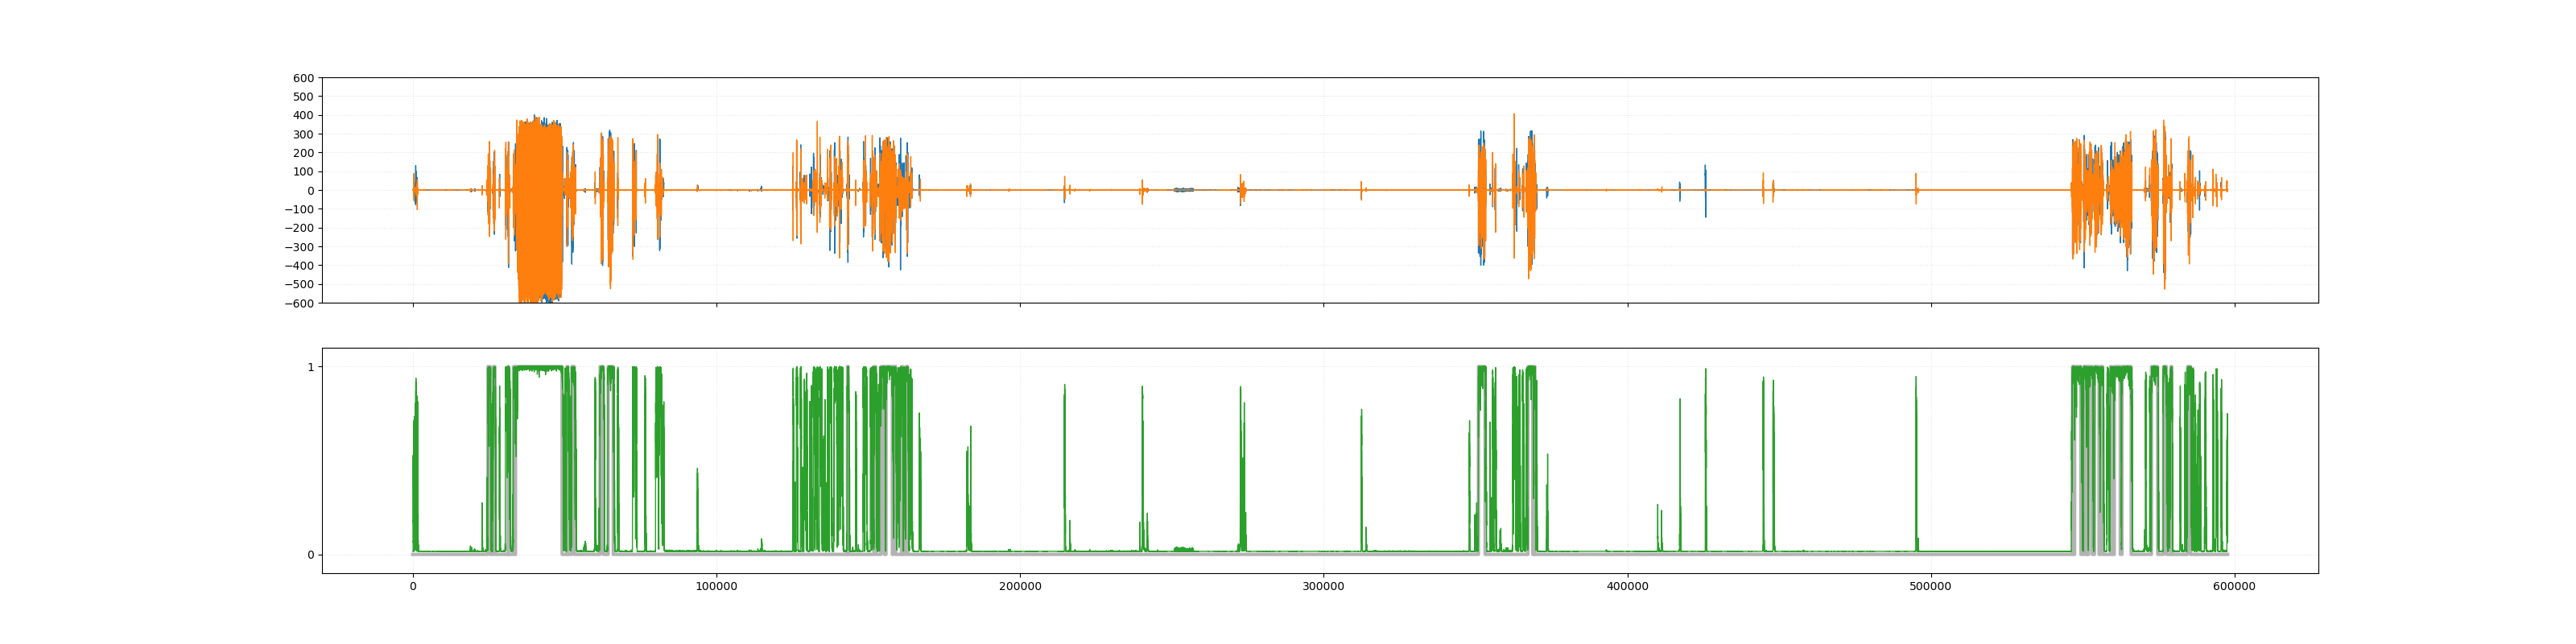

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(32, 8))
axs[0].plot(np.arange(len(features)), features[:,4], lw=1, c="tab:blue")
axs[0].plot(np.arange(len(features)), features[:,10], lw=1, c="tab:orange")
axs[0].set_ylim([-600, 600])
axs[0].yaxis.set_major_locator(plt.MultipleLocator(100.))
axs[0].grid(True, c=(0.9, 0.9, 0.9), ls=":")
axs[1].plot(np.arange(len(labels)), labels[:,0], lw=3, c=(0.7, 0.7, 0.7))
axs[1].plot(np.arange(predictions.shape[1]), predictions[0][:,0], lw=1, c="tab:green")
axs[1].set_ylim([-0.1, 1.1])
axs[1].set_yticks([0, 1])
axs[1].grid(True, c=(0.9, 0.9, 0.9), ls=":")
plt.show()

Split the train data into features and labels. For the labels, differentiate between labels for gait sequences and gait events.

In [4]:
X_train, y1_train, y2_train = train_data
y2_train = tf.keras.utils.to_categorical(y2_train, num_classes=5)
X_val, y1_val, y2_val = val_data
y2_val = tf.keras.utils.to_categorical(y2_val, num_classes=5)
print(f"Shape of train features: {X_train.shape}")
print(f"Shape of train labels: {y1_train.shape}")
print(f"Shape of train labels: {y2_train.shape}")
print(f"Shape of val features: {X_val.shape}")
print(f"Shape of val labels: {y1_val.shape}")
print(f"Shape of val labels: {y2_val.shape}")

Shape of train features: (50578, 640, 12)
Shape of train labels: (50578, 640, 1)
Shape of train labels: (50578, 640, 5)
Shape of val features: (22024, 640, 12)
Shape of val labels: (22024, 640, 1)
Shape of val labels: (22024, 640, 5)


Get a multi-output model that simultaneously classifies gait sequences as well as specific gait events.

In [5]:
model = get_multi_output_model(nb_channels=X_train.shape[-1], nb_classes = y2_train.shape[-1])
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "tcn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, 12)]   0                                            
____________________________________________________________________________________

Define callbacks to reduce the chance of overfitting.

In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience = 5,         # number of epochs in a row in which there is no improvement
        monitor = 'val_loss', # which performance metric to use
        mode = 'min'          # minimize or maximize the performance metric
    ),
    keras.callbacks.ModelCheckpoint(
        filepath = './training/00',
        monitor = 'val_loss',
        save_best_only = True,
        save_weight_only = False,
        mode = 'min'
    )
]

In [8]:
history = model.fit(
    x = X_train,
    y = {'gait_sequences': y1_train,
         'gait_events': y2_train},
    batch_size = 32,
    epochs = 3,
    shuffle = True,
    validation_data = (X_val, {
        'gait_sequences': y1_val,
        'gait_events': y2_val
    }),
    callbacks = callbacks
)

Epoch 1/3


TypeError: 'NoneType' object is not callable

In [11]:
predictions = multi_output_model.predict(x=train_features)

In [15]:
for i in range(len(predictions)):
    print(type(predictions[i]))
    print(predictions[i].shape)

<class 'numpy.ndarray'>
(16592, 640, 1)
<class 'numpy.ndarray'>
(16592, 640, 5)


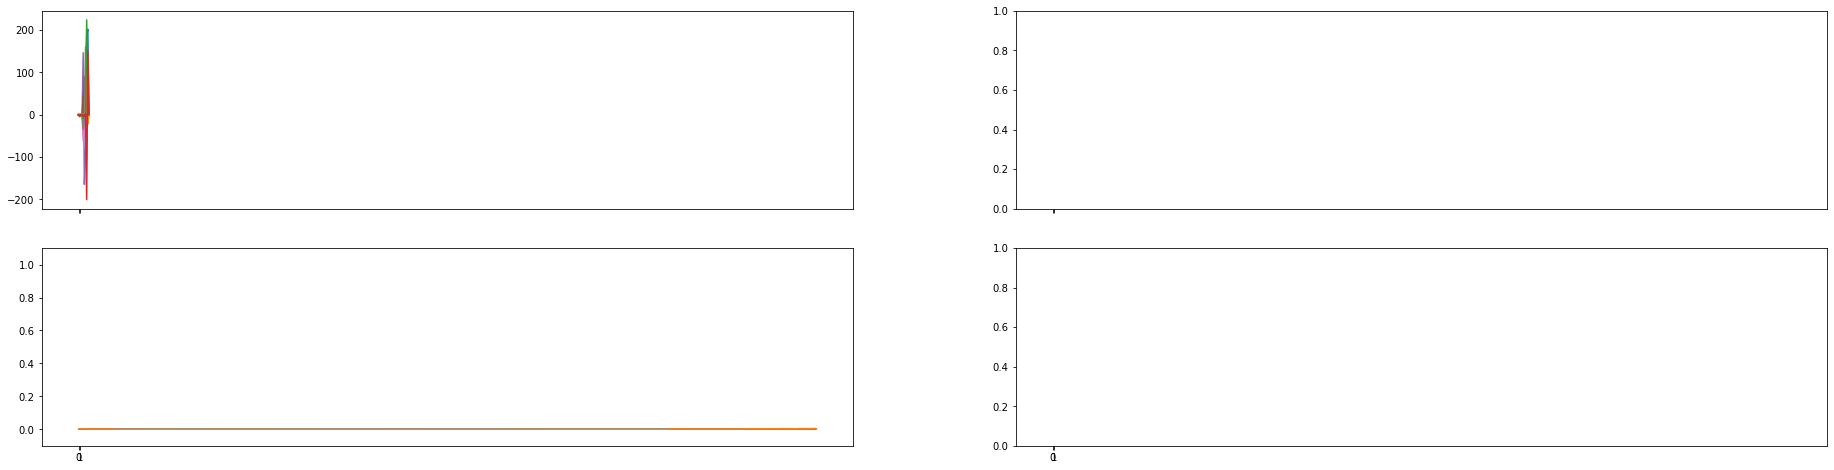

In [46]:
ix_random = np.random.choice(predictions[0].shape[0], 1, replace=False)[0]

fig, axs = plt.subplots(2, 2, figsize=(32, 8), sharex=True)
axs[0][0].plot(train_features[ix_random:ix_random+10][:,4])
axs[0][0].plot(train_features[ix_random:ix_random+10][:,10])
axs[1][0].plot(gait_labels[ix_random][:,0])
axs[1][0].plot(predictions[0][ix_random][:,0])
axs[1][0].set_ylim([-0.1, 1.1])
axs[1][0].set_xticks([0, 1])
plt.show()